# Training Notebook

In this solution notebook we focus on these key tasks:

1. Loading and visualization of the dataset
2. Running model predictions and evaluating baseline
3. Train model to improve score over this baseline
4. Run evaluations and explain the working of both the given model and trained model


In [11]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

In [1]:
from scripts.dataset_loader import TrainingDatasetLoader


loader = TrainingDatasetLoader(batch_size=32, test_size=0.2, seed=200)
dataset = loader.load_training_dataset()

dataset

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 16, 16), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 array([[[0.0996037 , 0.29187554, 0.39059043, ..., 0.03066519,
          0.28590906, 0.05687546],
         [1.0421138 , 1.0117004 , 0.86509436, ..., 0.17399733,
          0.81747395, 0.40096018],
         [0.3631118 , 0.97789145, 2.5230975 , ..., 0.7207844 ,
          0.8192355 , 0.04092123],
         ...,
         [0.52053326, 0.01886391, 0.0577553 , ..., 0.25856853,
          0.6895502 , 0.06748567],
         [0.478008  , 0.07698139, 0.29231417, ..., 0.2139124 ,
          0.28563604, 0.10399454],
         [0.35462713, 0.18483926, 0.41950527, ..., 0.03004529,
          0.07482819, 0.09263787]],
 
        [[2.3150485 , 1.9108704 , 1.2130682 , ..., 0.487955  ,
          0.8241669 , 0.31444633],

In [ ]:
import urllib

import optuna
from optuna.integration.tensorboard import TensorBoardCallback

import tensorflow as tf


fashion_mnist = tf.keras.datasets.fashion_mnist

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0


def train_test_model(num_units: int, dropout_rate: float, optimizer: str) -> float:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(num_units, activation=tf.nn.relu),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Dense(10, activation=tf.nn.softmax),
        ]
    )
    model.compile(
        optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
    )

    model.fit(x_train, y_train, epochs=1)  # Run with 1 epoch to speed things up for demo purposes
    _, accuracy = model.evaluate(x_test, y_test)
    return accuracy


def objective(trial: optuna.trial.Trial) -> float:
    num_units = trial.suggest_int("NUM_UNITS", 16, 32)
    dropout_rate = trial.suggest_float("DROPOUT_RATE", 0.1, 0.2)
    optimizer = trial.suggest_categorical("OPTIMIZER", ["sgd", "adam"])

    accuracy = train_test_model(num_units, dropout_rate, optimizer)  # type: ignore
    return accuracy


tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, timeout=600, callbacks=[tensorboard_callback])

/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/ipykernel_69124/1292893280.py:49: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")
[I 2025-03-04 14:59:21,897] A new study created in memory with name: no-name-4f417c21-3dc7-4607-88b1-f343f25cad42


313/313 [==============================] - 0s 318us/step - loss: 0.4699 - accuracy: 0.8322


[I 2025-03-04 14:59:23,502] Trial 0 finished with value: 0.8321999907493591 and parameters: {'NUM_UNITS': 29, 'DROPOUT_RATE': 0.13753663540490793, 'OPTIMIZER': 'adam'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 272us/step - loss: 0.6413 - accuracy: 0.7849


[I 2025-03-04 14:59:24,485] Trial 1 finished with value: 0.7849000096321106 and parameters: {'NUM_UNITS': 20, 'DROPOUT_RATE': 0.1932742179276148, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 301us/step - loss: 0.6421 - accuracy: 0.7757


[I 2025-03-04 14:59:25,606] Trial 2 finished with value: 0.7756999731063843 and parameters: {'NUM_UNITS': 22, 'DROPOUT_RATE': 0.15854292942228318, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 310us/step - loss: 0.6250 - accuracy: 0.7827


[I 2025-03-04 14:59:26,880] Trial 3 finished with value: 0.7827000021934509 and parameters: {'NUM_UNITS': 30, 'DROPOUT_RATE': 0.1755583975206587, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 276us/step - loss: 0.4864 - accuracy: 0.8255


[I 2025-03-04 14:59:28,149] Trial 4 finished with value: 0.8255000114440918 and parameters: {'NUM_UNITS': 19, 'DROPOUT_RATE': 0.15571240250982876, 'OPTIMIZER': 'adam'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 286us/step - loss: 0.4807 - accuracy: 0.8244


[I 2025-03-04 14:59:29,465] Trial 5 finished with value: 0.824400007724762 and parameters: {'NUM_UNITS': 23, 'DROPOUT_RATE': 0.1921856870906199, 'OPTIMIZER': 'adam'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 291us/step - loss: 0.6579 - accuracy: 0.7798


[I 2025-03-04 14:59:30,506] Trial 6 finished with value: 0.7797999978065491 and parameters: {'NUM_UNITS': 26, 'DROPOUT_RATE': 0.13354706855863832, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 279us/step - loss: 0.7000 - accuracy: 0.7528


[I 2025-03-04 14:59:31,483] Trial 7 finished with value: 0.7527999877929688 and parameters: {'NUM_UNITS': 16, 'DROPOUT_RATE': 0.18008779715107043, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 298us/step - loss: 0.6280 - accuracy: 0.7864


[I 2025-03-04 14:59:32,633] Trial 8 finished with value: 0.7864000201225281 and parameters: {'NUM_UNITS': 28, 'DROPOUT_RATE': 0.10729945424598397, 'OPTIMIZER': 'sgd'}. Best is trial 0 with value: 0.8321999907493591.


313/313 [==============================] - 0s 285us/step - loss: 0.4830 - accuracy: 0.8297


[I 2025-03-04 14:59:33,849] Trial 9 finished with value: 0.8296999931335449 and parameters: {'NUM_UNITS': 24, 'DROPOUT_RATE': 0.16477203781894273, 'OPTIMIZER': 'adam'}. Best is trial 0 with value: 0.8321999907493591.


In [4]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir logs

: 

## New stuff

In [17]:
from scripts.model_plots import create_neural_network_visualization
import numpy as np
import tensorflow as tf
from keras import Model, Input
from keras.layers import (
    Conv2D,
    Conv2DTranspose,
    MaxPooling2D,
    Flatten,
    Dense,
    Dropout,
    Reshape,
)


class AutoencoderModel:
    def __init__(
        self,
        input_shape=(16, 16, 1),
        filters=32,
        latent_dim=40,
        kernel_size=3,
        dropout_rate=0.1,
    ):
        """
        :param input_shape: shape of the input (H, W, C)
        :param filters: number of filters for the first Conv2D layer
        :param latent_dim: dimensionality of the latent vector
        :param kernel_size: kernel size for Conv2D layers
        :param dropout_rate: dropout probability
        """
        self.input_shape = input_shape
        self.filters = filters
        self.latent_dim = latent_dim
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate

    def get_model(self):
        # ----- Encoder -----
        inputs = Input(shape=self.input_shape, name="encoder_input")

        # First convolutional block
        x = Conv2D(
            self.filters,
            (self.kernel_size, self.kernel_size),
            padding="same",
            activation="relu",
        )(inputs)
        # Second convolutional block with doubled filters
        x = Conv2D(
            self.filters * 2,
            (self.kernel_size, self.kernel_size),
            padding="same",
            activation="relu",
        )(x)

        # Downsample with MaxPooling
        x = MaxPooling2D((2, 2))(x)

        # Flatten and apply dropout
        x = Flatten()(x)
        x = Dropout(self.dropout_rate)(x)

        # Latent space representation
        latent = Dense(self.latent_dim, activation="relu", name="latent")(x)

        # ----- Decoder -----
        # Expand latent space to a 2D feature map
        x = Dense(8 * 8 * (self.filters * 2), activation="relu")(latent)
        x = Reshape((8, 8, self.filters * 2))(x)
        # Upsample using Conv2DTranspose
        x = Conv2DTranspose(
            self.filters * 2,
            (self.kernel_size, self.kernel_size),
            strides=2,
            padding="same",
            activation="relu",
        )(x)

        # Final reconstruction layer
        outputs = Conv2D(
            1, (3, 3), activation="sigmoid", padding="same", name="decoder_output"
        )(x)

        return Model(inputs, outputs, name="autoencoder")


class ClassifierModel(Model):
    def __init__(self, encoder, num_classes):
        super(ClassifierModel, self).__init__()

        self.encoder = encoder
        self.encoder.trainable = False  # Optionally freeze encoder weights

        # Define additional dense layers
        self.dense2 = Dense(16, activation="relu")
        self.dense3 = Dense(8, activation="relu")
        self.output_layer = Dense(num_classes, activation="softmax")

    def call(self, inputs, training=False):
        # Freezing the encoder weights
        x = self.encoder(inputs, training=False)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return self.output_layer(x)


test_autoencoder_model = AutoencoderModel(
    input_shape=(16, 16, 1), filters=16, latent_dim=16, kernel_size=3, dropout_rate=0.0
).get_model()


create_neural_network_visualization(test_autoencoder_model, name="autoencoder")

Model Architecture Image saved to './plots/autoencoder_architecture.png'


/opt/homebrew/lib/python3.11/site-packages/visualkeras/layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


In [18]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import Model, Input, layers
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

import optuna
from optuna.integration.tensorboard import TensorBoardCallback

from scripts.model_evaluation import plot_confusion_matrix
from scripts.model_plots import plot_training_accuracy, plot_training_loss


loader = TrainingDatasetLoader(batch_size=32, test_size=0.2, seed=200)
(train_dataset, test_dataset, images_train, images_test, labels_train, labels_test) = (
    loader.load_training_dataset()
)

# Determine number of classes (assumes labels are integer-encoded)
num_classes = len(np.unique(labels_train))
print(f"Detected {num_classes} classes.")


# ----------------------------
# Define the Optuna Objective
# ----------------------------
def objective(trial):
    # Suggest hyperparameters
    filters = trial.suggest_int("filters", 16, 64, step=16)
    latent_dim = trial.suggest_int("latent_dim", 16, 64, step=16)
    kernel_size = trial.suggest_int("kernel_size", 3, 5)
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)

    # Build the autoencoder using the suggested hyperparameters
    autoencoder = AutoencoderModel(
        input_shape=(16, 16, 1),
        filters=filters,
        latent_dim=latent_dim,
        kernel_size=kernel_size,
        dropout_rate=dropout_rate,
    ).get_model()

    # Extract the encoder
    encoder = Model(autoencoder.input, autoencoder.get_layer("latent").output)

    # Build the classifier model using the encoder
    classifier_model = ClassifierModel(encoder, num_classes)

    # Compile the model with the suggested learning rate
    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    classifier_model.compile(
        optimizer=optimizer,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )

    # Train the model for a reduced number of epochs for tuning purposes
    epochs = 50
    history = classifier_model.fit(
        train_dataset, epochs=epochs, validation_data=test_dataset, verbose=0
    )

    # Return the best validation accuracy as the objective value
    best_val_acc = max(history.history["val_accuracy"])
    return best_val_acc

    # ----------------------------
    # Run the Optuna Study
    # ----------------------------


# Set up the TensorBoard callback from Optuna
tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")


study = optuna.create_study(direction="maximize")
study.optimize(
    objective,
    n_trials=20,
    callbacks=[tensorboard_callback],
)

print("Best trial:")
best_trial = study.best_trial
print("  Best Validation Accuracy: ", best_trial.value)
print("  Best Hyperparameters:")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# ----------------------------
# Retrain the Model with the Best Hyperparameters
# ----------------------------
best_params = best_trial.params
filters = best_params["filters"]
latent_dim = best_params["latent_dim"]
kernel_size = best_params["kernel_size"]
dropout_rate = best_params["dropout_rate"]
learning_rate = best_params["learning_rate"]

/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/ipykernel_34314/1077121868.py:75: ExperimentalWarning: TensorBoardCallback is experimental (supported from v2.0.0). The interface can change in the future.
  tensorboard_callback = TensorBoardCallback("logs/", metric_name="accuracy")
[I 2025-03-04 17:57:20,847] A new study created in memory with name: no-name-a69e7f7b-b6f9-43e1-8562-ffca51911e8c


/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/ipykernel_34314/1077121868.py:34: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
[W 2025-03-04 17:57:20,967] Trial 0 failed with parameters: {'filters': 32, 'latent_dim': 32, 'kernel_size': 4, 'dropout_rate': 0.0, 'learning_rate': 0.003996329461478978} because of the following error: AttributeError('in user code:\n\n    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *\n        return step_function(self, iterator)\n    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **\n        outputs = model.distribute_strategy.run(run_step, args=(data,))\n    File "/opt/homebrew/lib/python3.11/site-packag

Detected 2 classes.


AttributeError: in user code:

    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py", line 1080, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/__autograph_generated_fileb3c1c4xo.py", line 11, in tf__call
        x = ag__.converted_call(ag__.ld(self).dense1, (ag__.ld(x),), None, fscope)

    AttributeError: Exception encountered when calling layer 'classifier_model_27' (type ClassifierModel).
    
    in user code:
    
        File "/var/folders/59/q2yb2fpj1h36gmjgd793x7_w0000gn/T/ipykernel_34314/3396643917.py", line 103, in call  *
            x = self.dense1(x)
    
        AttributeError: 'ClassifierModel' object has no attribute 'dense1'
    
    
    Call arguments received by layer 'classifier_model_27' (type ClassifierModel):
      • inputs=tf.Tensor(shape=(None, 16, 16), dtype=float32)
      • training=True


Model: "classifier_model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_26 (Functional)       (None, 64)                281024    
                                                                 
 dense_132 (Dense)           multiple                  2080      
                                                                 
 dense_133 (Dense)           multiple                  528       
                                                                 
 dense_134 (Dense)           multiple                  136       
                                                                 
 dense_135 (Dense)           multiple                  18        
                                                                 
Total params: 283786 (1.08 MB)
Trainable params: 2762 (10.79 KB)
Non-trainable params: 281024 (1.07 MB)
_________________________________________________________________
Epoch 1/2

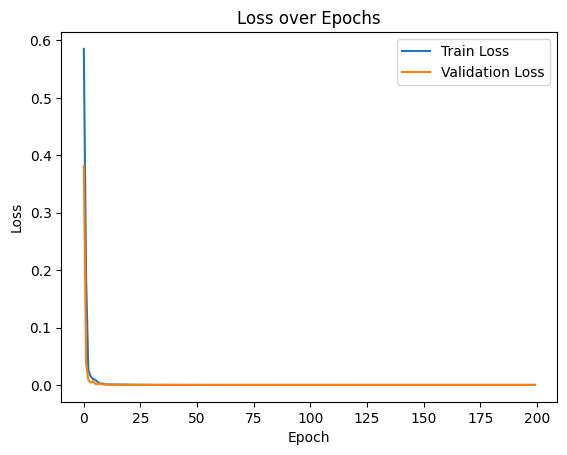

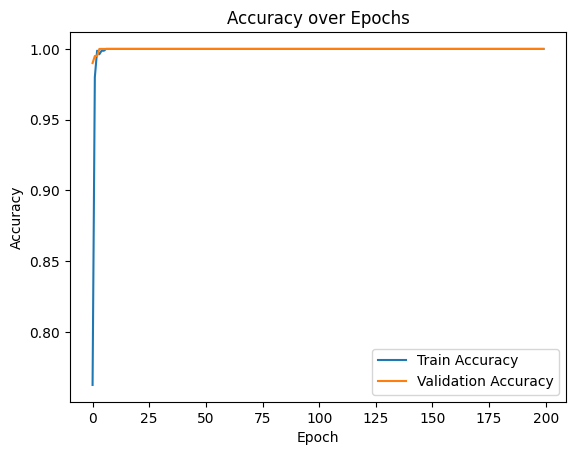

7/7 [==============================] - 0s 2ms/step


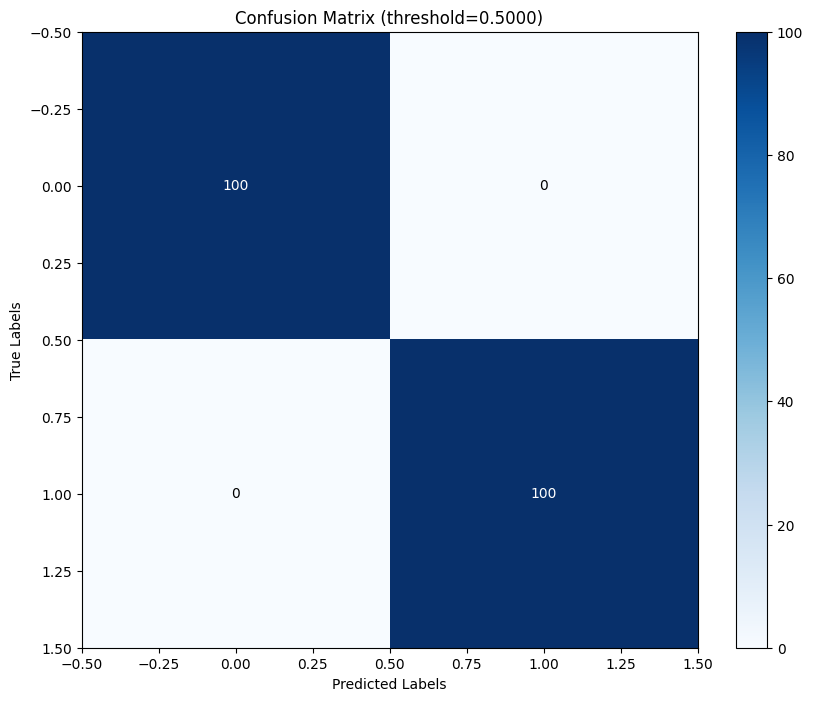

Classification Report:
 {'0': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 100.0}, '1': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 100.0}, 'accuracy': 1.0, 'macro avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 200.0}, 'weighted avg': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 200.0}}


In [16]:
# Rebuild the autoencoder and classifier using the best parameters
autoencoder = AutoencoderModel(
    input_shape=(16, 16, 1),
    filters=filters,
    latent_dim=latent_dim,
    kernel_size=kernel_size,
    dropout_rate=dropout_rate,
).get_model()

encoder = Model(autoencoder.input, autoencoder.get_layer("latent").output)
classifier_model = ClassifierModel(encoder, num_classes)

optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
classifier_model.compile(
    optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

# Build the model (for summary and initializing weights)
classifier_model.build(input_shape=(None, 16, 16, 1))
classifier_model.summary()

# Train the classifier with full training epochs
epochs = 200
history = classifier_model.fit(
    train_dataset,
    epochs=epochs,
    validation_data=test_dataset,
)

# ----------------------------
# Plot Training Metrics
# ----------------------------
plot_training_loss(history.history["loss"], history.history["val_loss"])
plot_training_accuracy(history.history["accuracy"], history.history["val_accuracy"])

# ----------------------------
# Evaluate the Final Model
# ----------------------------
pred_probs = classifier_model.predict(images_test)
pred_labels = np.argmax(pred_probs, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(labels_test, pred_labels)

# Print the classification report
report = classification_report(labels_test, pred_labels, output_dict=True)
print("Classification Report:\n", report)